In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2

import math

In [4]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
        X = np.array(X).reshape(48,48,1)
        
        y = int(self.dff.iloc[index]['emotion'])

        if self.transforms:
            X = self.transforms(np.uint8(X))

#             X = torch.cat((X,X,X),0)

        return X, y

In [5]:
batch_size= 128

df = pd.read_csv('/tf/data/Quan/fer2013/data/csv_file/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']

# CLAHE preprocessing
def clahe(x):
    x = np.array(x) # unit8
    x = cv2.normalize(x, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    x = x.astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    x = clahe.apply(x)
    
    return x

train_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

test_transforms = transforms.Compose([
    transforms.Lambda(clahe),
    transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_set = FERDataset(df_train, train_transforms)
val_set = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Baseline (4 blocks of VGG with bn)

In [10]:
class Baseline(nn.Module):
    def __init__(self, embeddings=False):
        
        super(Baseline, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = nn.Flatten()(x)
        x = self.classifier(x)
        
        return x

In [11]:
device = torch.device('cuda')
print(device)

model = Baseline()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [12]:
model = model.to(device)

model_path = './baseline_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.3310329914093018 Batch_id=224  Accuracy=38.65: 100%|██████████| 225/225 [00:32<00:00,  6.97it/s]

- Avg.loss: 1.607  | Avg.acc: 0.387



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.443  | Avg. val_acc: 0.456
* Update optimal model
Epoch:  2


Loss=1.2239130735397339 Batch_id=224  Accuracy=49.11: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


- Avg.loss: 1.345  | Avg.acc: 0.491


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.289  | Avg. val_acc: 0.510
* Update optimal model
Epoch:  3


Loss=1.3561136722564697 Batch_id=224  Accuracy=51.38: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.277  | Avg.acc: 0.514



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.296  | Avg. val_acc: 0.489
Epoch:  4


Loss=1.284887671470642 Batch_id=224  Accuracy=53.29: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s] 

- Avg.loss: 1.229  | Avg.acc: 0.533



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214  | Avg. val_acc: 0.537
* Update optimal model
Epoch:  5


Loss=1.3612074851989746 Batch_id=224  Accuracy=54.11: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.203  | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170  | Avg. val_acc: 0.558
* Update optimal model
Epoch:  6


Loss=1.134266972541809 Batch_id=224  Accuracy=54.97: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s] 

- Avg.loss: 1.179  | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.191  | Avg. val_acc: 0.545
Epoch:  7


Loss=1.0931081771850586 Batch_id=224  Accuracy=56.01: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]


- Avg.loss: 1.158  | Avg.acc: 0.560


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.156  | Avg. val_acc: 0.556
Epoch:  8


Loss=1.2563666105270386 Batch_id=224  Accuracy=56.70: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.145  | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.153  | Avg. val_acc: 0.563
* Update optimal model
Epoch:  9


Loss=1.1629117727279663 Batch_id=224  Accuracy=57.27: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]

- Avg.loss: 1.129  | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.138  | Avg. val_acc: 0.574
* Update optimal model
Epoch:  10


Loss=1.0561546087265015 Batch_id=224  Accuracy=57.24: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.119  | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134  | Avg. val_acc: 0.567
Epoch:  11


Loss=0.932741641998291 Batch_id=224  Accuracy=57.82: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 1.115  | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157  | Avg. val_acc: 0.561
Epoch:  12


Loss=1.2030348777770996 Batch_id=224  Accuracy=58.14: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.100  | Avg.acc: 0.581



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116  | Avg. val_acc: 0.567
Epoch:  13


Loss=0.9866688847541809 Batch_id=224  Accuracy=58.55: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.094  | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130  | Avg. val_acc: 0.572
Epoch:  14


Loss=0.941982090473175 Batch_id=224  Accuracy=58.67: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s] 

- Avg.loss: 1.091  | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113  | Avg. val_acc: 0.576
* Update optimal model
Epoch:  15


Loss=1.1815532445907593 Batch_id=224  Accuracy=59.05: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.079  | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.130  | Avg. val_acc: 0.579
* Update optimal model
Epoch:  16


Loss=0.9396145939826965 Batch_id=224  Accuracy=58.76: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.078  | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087  | Avg. val_acc: 0.590
* Update optimal model
Epoch:  17


Loss=0.744350254535675 Batch_id=224  Accuracy=59.15: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s] 

- Avg.loss: 1.080  | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.119  | Avg. val_acc: 0.583
Epoch:  18


Loss=0.9601671099662781 Batch_id=224  Accuracy=59.24: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 1.078  | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114  | Avg. val_acc: 0.585
Epoch:  19


Loss=1.0867365598678589 Batch_id=224  Accuracy=59.59: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


- Avg.loss: 1.063  | Avg.acc: 0.596


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.102  | Avg. val_acc: 0.579
Epoch:  20


Loss=0.9681229591369629 Batch_id=224  Accuracy=59.73: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.062  | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096  | Avg. val_acc: 0.587
Epoch:  21


Loss=0.972771942615509 Batch_id=224  Accuracy=59.77: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s] 

- Avg.loss: 1.062  | Avg.acc: 0.598



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074  | Avg. val_acc: 0.596
* Update optimal model
Epoch:  22


Loss=0.9692283868789673 Batch_id=224  Accuracy=59.90: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 1.057  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.121  | Avg. val_acc: 0.575
Epoch:  23


Loss=0.9625683426856995 Batch_id=224  Accuracy=60.34: 100%|██████████| 225/225 [00:30<00:00,  7.47it/s]

- Avg.loss: 1.050  | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.601
* Update optimal model
Epoch:  24


Loss=1.3121631145477295 Batch_id=224  Accuracy=60.32: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.043  | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.595
Epoch:  25


Loss=1.2354563474655151 Batch_id=224  Accuracy=60.60: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.046  | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.095  | Avg. val_acc: 0.590
Epoch:  26


Loss=1.0273127555847168 Batch_id=224  Accuracy=60.43: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.044  | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.098  | Avg. val_acc: 0.599
Epoch:  27


Loss=1.1599750518798828 Batch_id=224  Accuracy=60.46: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]

- Avg.loss: 1.044  | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.117  | Avg. val_acc: 0.584
Epoch:  28


Loss=1.108352780342102 Batch_id=224  Accuracy=60.52: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s] 

- Avg.loss: 1.036  | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083  | Avg. val_acc: 0.587
Epoch:  29


Loss=0.903448760509491 Batch_id=224  Accuracy=60.98: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s] 

- Avg.loss: 1.032  | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.600
Epoch:  30


Loss=1.3307876586914062 Batch_id=224  Accuracy=60.75: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.039  | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.058  | Avg. val_acc: 0.609
* Update optimal model
Epoch:  31


Loss=1.2601083517074585 Batch_id=224  Accuracy=61.28: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.023  | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.603
Epoch:  32


Loss=1.2059500217437744 Batch_id=224  Accuracy=61.39: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.020  | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.587
Epoch:  33


Loss=1.0343159437179565 Batch_id=224  Accuracy=61.27: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 1.025  | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073  | Avg. val_acc: 0.598
Epoch:  34


Loss=0.9151248335838318 Batch_id=224  Accuracy=61.20: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 1.021  | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076  | Avg. val_acc: 0.600
Epoch:  35


Loss=1.0942974090576172 Batch_id=224  Accuracy=61.59: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 1.018  | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.050  | Avg. val_acc: 0.608
Epoch:  36


Loss=1.156219244003296 Batch_id=224  Accuracy=61.51: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s] 

- Avg.loss: 1.017  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059  | Avg. val_acc: 0.603
Epoch:  37


Loss=1.179399847984314 Batch_id=224  Accuracy=61.40: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 1.017  | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.598
Epoch:  38


Loss=0.8474460244178772 Batch_id=224  Accuracy=61.74: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.017  | Avg.acc: 0.617



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.043  | Avg. val_acc: 0.607
Epoch:  39


Loss=0.8026978373527527 Batch_id=224  Accuracy=61.93: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s]

- Avg.loss: 1.012  | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052  | Avg. val_acc: 0.609
* Update optimal model
Epoch:  40


Loss=0.9833229780197144 Batch_id=224  Accuracy=61.65: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 1.010  | Avg.acc: 0.616



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068  | Avg. val_acc: 0.605
Epoch:  41


Loss=1.1807258129119873 Batch_id=224  Accuracy=62.10: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]

- Avg.loss: 1.008  | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079  | Avg. val_acc: 0.606
Epoch:  42


Loss=0.8079442381858826 Batch_id=224  Accuracy=62.19: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.003  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.103  | Avg. val_acc: 0.594
Epoch:  43


Loss=1.0360326766967773 Batch_id=224  Accuracy=62.22: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.000  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.108  | Avg. val_acc: 0.577
Epoch:  44


Loss=1.0297738313674927 Batch_id=224  Accuracy=62.13: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.000  | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.091  | Avg. val_acc: 0.592
Epoch:  45


Loss=1.1103936433792114 Batch_id=224  Accuracy=62.20: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 1.004  | Avg.acc: 0.622



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052  | Avg. val_acc: 0.609
* Update optimal model
Epoch:  46


Loss=1.031461477279663 Batch_id=224  Accuracy=62.12: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s] 

- Avg.loss: 0.996  | Avg.acc: 0.621



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057  | Avg. val_acc: 0.602
Epoch:  47


Loss=1.1697793006896973 Batch_id=224  Accuracy=62.07: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


- Avg.loss: 0.997  | Avg.acc: 0.621


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073  | Avg. val_acc: 0.604
Epoch    47: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  48


Loss=1.104023814201355 Batch_id=224  Accuracy=64.35: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 0.951  | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.039  | Avg. val_acc: 0.609
Epoch:  49


Loss=0.7579025030136108 Batch_id=224  Accuracy=64.89: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.929  | Avg.acc: 0.649



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018  | Avg. val_acc: 0.618
* Update optimal model
Epoch:  50


Loss=1.096550703048706 Batch_id=224  Accuracy=65.26: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 0.924  | Avg.acc: 0.653



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026  | Avg. val_acc: 0.615
Epoch:  51


Loss=0.8903239369392395 Batch_id=224  Accuracy=65.55: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]

- Avg.loss: 0.916  | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014  | Avg. val_acc: 0.629
* Update optimal model
Epoch:  52


Loss=1.006717562675476 Batch_id=224  Accuracy=65.71: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s] 

- Avg.loss: 0.914  | Avg.acc: 0.657



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033  | Avg. val_acc: 0.622
Epoch:  53


Loss=0.710237443447113 Batch_id=224  Accuracy=65.56: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s] 

- Avg.loss: 0.909  | Avg.acc: 0.656



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021  | Avg. val_acc: 0.626
Epoch:  54


Loss=0.8448026776313782 Batch_id=224  Accuracy=65.91: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.904  | Avg.acc: 0.659



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020  | Avg. val_acc: 0.627
Epoch:  55


Loss=0.5267999768257141 Batch_id=224  Accuracy=66.37: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 0.895  | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.042  | Avg. val_acc: 0.617
Epoch:  56


Loss=0.9816461801528931 Batch_id=224  Accuracy=66.35: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.896  | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056  | Avg. val_acc: 0.607
Epoch:  57


Loss=1.1109143495559692 Batch_id=224  Accuracy=66.62: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.891  | Avg.acc: 0.666



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030  | Avg. val_acc: 0.619
Epoch:  58


Loss=0.9860268831253052 Batch_id=224  Accuracy=66.69: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.886  | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026  | Avg. val_acc: 0.631
* Update optimal model
Epoch:  59


Loss=0.8178582787513733 Batch_id=224  Accuracy=66.93: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.886  | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035  | Avg. val_acc: 0.624
Epoch:  60


Loss=1.2672185897827148 Batch_id=224  Accuracy=67.04: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.877  | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047  | Avg. val_acc: 0.614
Epoch    60: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  61


Loss=0.8757432699203491 Batch_id=224  Accuracy=68.05: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.846  | Avg.acc: 0.680



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.023  | Avg. val_acc: 0.633
* Update optimal model
Epoch:  62


Loss=1.0956639051437378 Batch_id=224  Accuracy=69.22: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 0.824  | Avg.acc: 0.692



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035  | Avg. val_acc: 0.634
* Update optimal model
Epoch:  63


Loss=0.8031453490257263 Batch_id=224  Accuracy=69.49: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 0.818  | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028  | Avg. val_acc: 0.630
Epoch:  64


Loss=0.6524938941001892 Batch_id=224  Accuracy=69.81: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.810  | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031  | Avg. val_acc: 0.637
* Update optimal model
Epoch:  65


Loss=1.009189248085022 Batch_id=224  Accuracy=70.22: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 0.804  | Avg.acc: 0.702



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029  | Avg. val_acc: 0.633
Epoch:  66


Loss=0.7258749008178711 Batch_id=224  Accuracy=70.57: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.790  | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038  | Avg. val_acc: 0.636
Epoch:  67


Loss=1.0012221336364746 Batch_id=224  Accuracy=70.54: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]


- Avg.loss: 0.790  | Avg.acc: 0.705


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.045  | Avg. val_acc: 0.634
Epoch:  68


Loss=0.915823221206665 Batch_id=224  Accuracy=70.34: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s] 

- Avg.loss: 0.790  | Avg.acc: 0.703



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037  | Avg. val_acc: 0.636
Epoch:  69


Loss=0.9165720343589783 Batch_id=224  Accuracy=70.59: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.788  | Avg.acc: 0.706



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.061  | Avg. val_acc: 0.628
Epoch    69: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  70


Loss=0.8950037360191345 Batch_id=224  Accuracy=71.91: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.753  | Avg.acc: 0.719



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.635
Epoch:  71


Loss=0.8371865749359131 Batch_id=224  Accuracy=72.31: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.747  | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034  | Avg. val_acc: 0.638
* Update optimal model
Epoch:  72


Loss=0.8080320954322815 Batch_id=224  Accuracy=72.66: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.735  | Avg.acc: 0.727



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.640
* Update optimal model
Epoch:  73


Loss=0.6245922446250916 Batch_id=224  Accuracy=73.09: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.728  | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.639
Epoch:  74


Loss=0.7257570028305054 Batch_id=224  Accuracy=73.40: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.723  | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.059  | Avg. val_acc: 0.633
Epoch:  75


Loss=0.7426491975784302 Batch_id=224  Accuracy=73.29: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]

- Avg.loss: 0.717  | Avg.acc: 0.733



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.070  | Avg. val_acc: 0.640
Epoch:  76


Loss=0.8161176443099976 Batch_id=224  Accuracy=73.42: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 0.716  | Avg.acc: 0.734



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.077  | Avg. val_acc: 0.636
Epoch:  77


Loss=0.43384677171707153 Batch_id=224  Accuracy=73.65: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.710  | Avg.acc: 0.736



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068  | Avg. val_acc: 0.635
Epoch:  78


Loss=1.2164503335952759 Batch_id=224  Accuracy=73.79: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s] 

- Avg.loss: 0.705  | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.082  | Avg. val_acc: 0.636
Epoch    78: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  79


Loss=1.120244026184082 Batch_id=224  Accuracy=74.58: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]  

- Avg.loss: 0.690  | Avg.acc: 0.746



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068  | Avg. val_acc: 0.638
Epoch:  80


Loss=0.7389973998069763 Batch_id=224  Accuracy=74.65: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.684  | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066  | Avg. val_acc: 0.638
Epoch:  81


Loss=0.6063213348388672 Batch_id=224  Accuracy=74.54: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 0.684  | Avg.acc: 0.745



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057  | Avg. val_acc: 0.645
* Update optimal model
Epoch:  82


Loss=0.850424587726593 Batch_id=224  Accuracy=75.11: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s] 

- Avg.loss: 0.677  | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069  | Avg. val_acc: 0.639
Epoch:  83


Loss=0.5977754592895508 Batch_id=224  Accuracy=75.50: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 0.670  | Avg.acc: 0.755



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074  | Avg. val_acc: 0.639
Epoch:  84


Loss=0.7792158126831055 Batch_id=224  Accuracy=75.20: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.666  | Avg.acc: 0.752



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076  | Avg. val_acc: 0.639
Epoch:  85


Loss=0.7680326104164124 Batch_id=224  Accuracy=75.72: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s] 

- Avg.loss: 0.658  | Avg.acc: 0.757



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.641
Epoch:  86


Loss=0.7799224853515625 Batch_id=224  Accuracy=75.88: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s] 

- Avg.loss: 0.656  | Avg.acc: 0.759



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.078  | Avg. val_acc: 0.637
Epoch:  87


Loss=0.6550419330596924 Batch_id=224  Accuracy=75.78: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.662  | Avg.acc: 0.758



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.072  | Avg. val_acc: 0.643
Epoch    87: reducing learning rate of group 0 to 1.2500e-04.
Epoch:  88


Loss=0.6007534265518188 Batch_id=224  Accuracy=76.21: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 0.647  | Avg.acc: 0.762



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.644
Epoch:  89


Loss=0.7504745125770569 Batch_id=224  Accuracy=76.33: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s] 

- Avg.loss: 0.644  | Avg.acc: 0.763



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084  | Avg. val_acc: 0.646
* Update optimal model
Epoch:  90


Loss=0.6948707699775696 Batch_id=224  Accuracy=75.97: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.647  | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.089  | Avg. val_acc: 0.638
Epoch:  91


Loss=0.7619529366493225 Batch_id=224  Accuracy=76.53: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s] 

- Avg.loss: 0.641  | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.074  | Avg. val_acc: 0.642
Epoch:  92


Loss=0.716535210609436 Batch_id=224  Accuracy=76.49: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]  

- Avg.loss: 0.640  | Avg.acc: 0.765



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.083  | Avg. val_acc: 0.642
Epoch:  93


Loss=0.9168956875801086 Batch_id=224  Accuracy=76.60: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.640  | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.087  | Avg. val_acc: 0.643
Epoch:  94


Loss=0.7350541353225708 Batch_id=224  Accuracy=76.58: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]

- Avg.loss: 0.639  | Avg.acc: 0.766



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079  | Avg. val_acc: 0.638
Epoch:  95


Loss=0.858664333820343 Batch_id=224  Accuracy=76.84: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]  

- Avg.loss: 0.634  | Avg.acc: 0.768



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084  | Avg. val_acc: 0.639
Epoch:  96


Loss=0.7768396139144897 Batch_id=224  Accuracy=76.70: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s] 


- Avg.loss: 0.637  | Avg.acc: 0.767


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099  | Avg. val_acc: 0.638
Epoch    96: reducing learning rate of group 0 to 6.2500e-05.
Epoch:  97


Loss=0.5305739045143127 Batch_id=224  Accuracy=76.85: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.633  | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.640
Epoch:  98


Loss=0.91424959897995 Batch_id=224  Accuracy=76.94: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]   

- Avg.loss: 0.630  | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.642
Epoch:  99


Loss=0.7817293405532837 Batch_id=224  Accuracy=76.95: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.629  | Avg.acc: 0.769



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093  | Avg. val_acc: 0.644
Epoch:  100


Loss=0.6265630722045898 Batch_id=224  Accuracy=77.02: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.625  | Avg.acc: 0.770


- Avg. val_loss: 1.088  | Avg. val_acc: 0.641
Finished Training


([<matplotlib.lines.Line2D at 0x7fe99879fb70>,
 0.6464196154917804,
 1.0842781422961287)

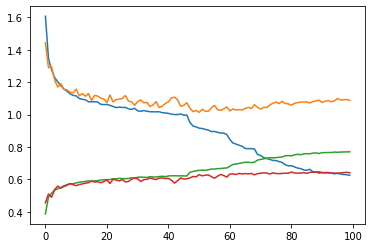

In [14]:
import pickle
pickle.dump(hist, open('./baseline_hist.hdf5', 'wb'))
plt.plot(hist), best_acc, curloss

In [16]:
# EVALUATE
model = torch.load('./baseline_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_preds = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc
    
    _preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
    _labels.append(labels.cpu().numpy())

_preds = np.concatenate(_preds)
_labels = np.concatenate(_labels)
print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.006  | Avg. val_acc: 0.654


Text(0.5, 1, 'baseline')

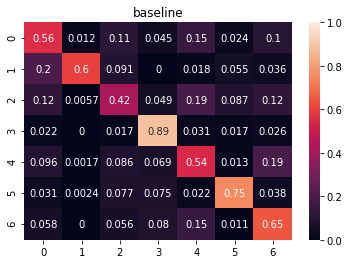

In [21]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

sn.heatmap(confusion_matrix(_labels, _preds, normalize='true'), annot=True, vmin=0, vmax=1)
plt.title('baseline')

## Add residual block

In [29]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), stride=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        
        return x

In [30]:
class ResidualBaseline(nn.Module):
    def __init__(self):
        
        super(ResidualBaseline, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        
        self.residual_0_2 = ResidualBlock(32, 64)
        self.residual_1_3 = ResidualBlock(64, 128)
        self.residual_2_out = ResidualBlock(128, 256)
    
        self.classifier = nn.Sequential(nn.Flatten(),
                                        nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                        nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                        nn.Linear(128, 7), nn.BatchNorm1d(7))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x_0 = self.maxpool(x)
        
        x = self.conv1(x_0)
        x = self.bn1(x)
        
        #residual 0_2 before relu
        x0_2 = self.residual_0_2(x_0)
        x = x + x0_2
        
        x = self.relu(x)
        
        x_1 = self.maxpool(x)
        
        x = self.conv2(x_1)
        x = self.bn2(x)
        
        # residual 1_3 before relu
        x1_3 = self.residual_1_3(x_1)
        x = x + x1_3
        
        x = self.relu(x)
        
        x_2 = self.maxpool(x)
        
        x = self.conv3(x_2)
        x = self.bn3(x)
        
        # residual 2_out before relu
        x2_out = self.residual_2_out(x_2)
        x = x + x2_out
        
        x = self.relu(x)
        
        x = self.maxpool(x)
        
        x = nn.Flatten()(x)
        x = self.classifier(x)
        
        return x

In [31]:
device = torch.device('cuda')
print(device)

model = ResidualBaseline()

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

cuda


In [32]:
model = model.to(device)

model_path = './residual_baseline_model.pt'

best_acc = 0.0
curloss = 0.0
hist = []

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}  Accuracy={100*running_acc/processed:0.2f}')

    print('- Avg.loss: %.3f  | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
        loss = criterion(outputs, labels)
        
#         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc

    print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalcc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalcc])
    
    if best_acc < (running_valacc / len(val_loader.dataset)):
        best_acc = (running_valacc / len(val_loader.dataset))
        curloss = (running_valloss / len(val_loader.dataset))
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.441920280456543 Batch_id=224  Accuracy=40.72: 100%|██████████| 225/225 [00:32<00:00,  6.86it/s] 

- Avg.loss: 1.578  | Avg.acc: 0.407



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.375  | Avg. val_acc: 0.481
* Update optimal model
Epoch:  2


Loss=1.4671913385391235 Batch_id=224  Accuracy=49.07: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.339  | Avg.acc: 0.491



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.306  | Avg. val_acc: 0.507
* Update optimal model
Epoch:  3


Loss=1.475764513015747 Batch_id=224  Accuracy=51.47: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s] 

- Avg.loss: 1.270  | Avg.acc: 0.515



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.224  | Avg. val_acc: 0.535
* Update optimal model
Epoch:  4


Loss=1.2278136014938354 Batch_id=224  Accuracy=53.42: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 1.227  | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.193  | Avg. val_acc: 0.548
* Update optimal model
Epoch:  5


Loss=1.2859996557235718 Batch_id=224  Accuracy=54.49: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.199  | Avg.acc: 0.545



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139  | Avg. val_acc: 0.569
* Update optimal model
Epoch:  6


Loss=1.2751643657684326 Batch_id=224  Accuracy=55.02: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 1.179  | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195  | Avg. val_acc: 0.551
Epoch:  7


Loss=1.085686445236206 Batch_id=224  Accuracy=55.39: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 1.165  | Avg.acc: 0.554



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.189  | Avg. val_acc: 0.550
Epoch:  8


Loss=1.1447819471359253 Batch_id=224  Accuracy=56.15: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.146  | Avg.acc: 0.562



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.162  | Avg. val_acc: 0.566
Epoch:  9


Loss=1.0499331951141357 Batch_id=224  Accuracy=57.44: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 1.134  | Avg.acc: 0.574



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.150  | Avg. val_acc: 0.569
Epoch:  10


Loss=1.5068777799606323 Batch_id=224  Accuracy=57.24: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.126  | Avg.acc: 0.572



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.175  | Avg. val_acc: 0.549
Epoch:  11


Loss=1.4380238056182861 Batch_id=224  Accuracy=57.61: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.121  | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.247  | Avg. val_acc: 0.539
Epoch:  12


Loss=1.247070074081421 Batch_id=224  Accuracy=57.80: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s] 

- Avg.loss: 1.110  | Avg.acc: 0.578



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.597
* Update optimal model
Epoch:  13


Loss=0.8522694110870361 Batch_id=224  Accuracy=58.24: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 1.106  | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.592
Epoch:  14


Loss=0.946479082107544 Batch_id=224  Accuracy=58.55: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s] 

- Avg.loss: 1.098  | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.114  | Avg. val_acc: 0.585
Epoch:  15


Loss=0.9696754217147827 Batch_id=224  Accuracy=58.78: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 1.090  | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.105  | Avg. val_acc: 0.595
Epoch:  16


Loss=0.979117214679718 Batch_id=224  Accuracy=58.47: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 1.095  | Avg.acc: 0.585



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.128  | Avg. val_acc: 0.572
Epoch:  17


Loss=1.457387924194336 Batch_id=224  Accuracy=59.05: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s] 

- Avg.loss: 1.083  | Avg.acc: 0.591



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.309  | Avg. val_acc: 0.511
Epoch:  18


Loss=0.8977498412132263 Batch_id=224  Accuracy=59.25: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.079  | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248  | Avg. val_acc: 0.538
Epoch:  19


Loss=1.4026578664779663 Batch_id=224  Accuracy=59.51: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 1.075  | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.116  | Avg. val_acc: 0.588
Epoch:  20


Loss=1.1579716205596924 Batch_id=224  Accuracy=59.55: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 1.065  | Avg.acc: 0.596



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.145  | Avg. val_acc: 0.569
Epoch:  21


Loss=1.0546551942825317 Batch_id=224  Accuracy=59.52: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 1.072  | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085  | Avg. val_acc: 0.595
Epoch:  22


Loss=0.964687168598175 Batch_id=224  Accuracy=59.70: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s] 

- Avg.loss: 1.063  | Avg.acc: 0.597



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.081  | Avg. val_acc: 0.584
Epoch:  23


Loss=0.7884647846221924 Batch_id=224  Accuracy=59.94: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 1.056  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076  | Avg. val_acc: 0.593
Epoch:  24


Loss=1.0029257535934448 Batch_id=224  Accuracy=60.11: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 1.057  | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.093  | Avg. val_acc: 0.590
Epoch:  25


Loss=1.0140926837921143 Batch_id=224  Accuracy=59.94: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 1.059  | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.079  | Avg. val_acc: 0.583
Epoch:  26


Loss=1.1835936307907104 Batch_id=224  Accuracy=60.06: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.052  | Avg.acc: 0.601



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069  | Avg. val_acc: 0.596
Epoch:  27


Loss=1.221045970916748 Batch_id=224  Accuracy=60.20: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s] 

- Avg.loss: 1.047  | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.092  | Avg. val_acc: 0.584
Epoch:  28


Loss=1.169366717338562 Batch_id=224  Accuracy=60.38: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 1.046  | Avg.acc: 0.604



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.073  | Avg. val_acc: 0.593
Epoch:  29


Loss=1.1361616849899292 Batch_id=224  Accuracy=60.64: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 1.041  | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.147  | Avg. val_acc: 0.570
Epoch:  30


Loss=1.1658903360366821 Batch_id=224  Accuracy=60.88: 100%|██████████| 225/225 [00:31<00:00,  7.05it/s]

- Avg.loss: 1.040  | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.066  | Avg. val_acc: 0.590
Epoch:  31


Loss=1.2126346826553345 Batch_id=224  Accuracy=60.63: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 1.044  | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.590
Epoch:  32


Loss=1.057583212852478 Batch_id=224  Accuracy=60.99: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s] 

- Avg.loss: 1.031  | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.064  | Avg. val_acc: 0.605
* Update optimal model
Epoch:  33


Loss=1.1157833337783813 Batch_id=224  Accuracy=60.94: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]

- Avg.loss: 1.034  | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063  | Avg. val_acc: 0.604
Epoch:  34


Loss=1.1358239650726318 Batch_id=224  Accuracy=61.36: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 1.026  | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.090  | Avg. val_acc: 0.591
Epoch:  35


Loss=1.0777158737182617 Batch_id=224  Accuracy=61.07: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 1.026  | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.044  | Avg. val_acc: 0.612
* Update optimal model
Epoch:  36


Loss=0.7512478828430176 Batch_id=224  Accuracy=61.17: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 1.030  | Avg.acc: 0.612



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.084  | Avg. val_acc: 0.590
Epoch:  37


Loss=0.9140414595603943 Batch_id=224  Accuracy=61.06: 100%|██████████| 225/225 [00:31<00:00,  7.15it/s]

- Avg.loss: 1.026  | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088  | Avg. val_acc: 0.594
Epoch:  38


Loss=1.1202898025512695 Batch_id=224  Accuracy=60.93: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]

- Avg.loss: 1.023  | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.086  | Avg. val_acc: 0.596
Epoch:  39


Loss=0.9066619873046875 Batch_id=224  Accuracy=61.55: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]

- Avg.loss: 1.018  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118  | Avg. val_acc: 0.571
Epoch:  40


Loss=1.3137625455856323 Batch_id=224  Accuracy=61.87: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 1.014  | Avg.acc: 0.619



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.088  | Avg. val_acc: 0.587
Epoch:  41


Loss=1.1419756412506104 Batch_id=224  Accuracy=60.97: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 1.021  | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.071  | Avg. val_acc: 0.605
Epoch:  42


Loss=1.1686718463897705 Batch_id=224  Accuracy=61.12: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 1.021  | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080  | Avg. val_acc: 0.596
Epoch:  43


Loss=1.0429234504699707 Batch_id=224  Accuracy=61.50: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 1.014  | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.069  | Avg. val_acc: 0.603
Epoch:  44


Loss=1.2443838119506836 Batch_id=224  Accuracy=61.75: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 1.011  | Avg.acc: 0.618



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067  | Avg. val_acc: 0.590
Epoch    44: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  45


Loss=1.0555446147918701 Batch_id=224  Accuracy=63.92: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.957  | Avg.acc: 0.639



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.010  | Avg. val_acc: 0.630
* Update optimal model
Epoch:  46


Loss=1.0564982891082764 Batch_id=224  Accuracy=64.78: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.936  | Avg.acc: 0.648



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.030  | Avg. val_acc: 0.624
Epoch:  47


Loss=0.9529902338981628 Batch_id=224  Accuracy=65.03: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 0.931  | Avg.acc: 0.650



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028  | Avg. val_acc: 0.614
Epoch:  48


Loss=0.7995124459266663 Batch_id=224  Accuracy=65.07: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.928  | Avg.acc: 0.651



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.028  | Avg. val_acc: 0.610
Epoch:  49


Loss=0.8530135154724121 Batch_id=224  Accuracy=65.47: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]

- Avg.loss: 0.918  | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027  | Avg. val_acc: 0.629
Epoch:  50


Loss=0.7524709701538086 Batch_id=224  Accuracy=65.80: 100%|██████████| 225/225 [00:31<00:00,  7.10it/s]

- Avg.loss: 0.909  | Avg.acc: 0.658



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.006  | Avg. val_acc: 0.626
Epoch:  51


Loss=1.0049313306808472 Batch_id=224  Accuracy=66.04: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.909  | Avg.acc: 0.660



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040  | Avg. val_acc: 0.613
Epoch:  52


Loss=1.0613526105880737 Batch_id=224  Accuracy=65.47: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.912  | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.031  | Avg. val_acc: 0.615
Epoch:  53


Loss=0.8491381406784058 Batch_id=224  Accuracy=66.15: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.907  | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.022  | Avg. val_acc: 0.622
Epoch:  54


Loss=0.88556307554245 Batch_id=224  Accuracy=66.37: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]  

- Avg.loss: 0.899  | Avg.acc: 0.664



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033  | Avg. val_acc: 0.620
Epoch:  55


Loss=0.8300042152404785 Batch_id=224  Accuracy=66.47: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.890  | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.027  | Avg. val_acc: 0.617
Epoch:  56


Loss=0.9110690951347351 Batch_id=224  Accuracy=66.72: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.889  | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.026  | Avg. val_acc: 0.625
Epoch:  57


Loss=0.9326982498168945 Batch_id=224  Accuracy=66.51: 100%|██████████| 225/225 [00:31<00:00,  7.12it/s]

- Avg.loss: 0.884  | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.046  | Avg. val_acc: 0.612
Epoch:  58


Loss=0.900343120098114 Batch_id=224  Accuracy=66.88: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s] 

- Avg.loss: 0.883  | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035  | Avg. val_acc: 0.615
Epoch:  59


Loss=0.8555593490600586 Batch_id=224  Accuracy=66.96: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.883  | Avg.acc: 0.670



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.037  | Avg. val_acc: 0.626
Epoch    59: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  60


Loss=0.7192566394805908 Batch_id=224  Accuracy=68.09: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.842  | Avg.acc: 0.681



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007  | Avg. val_acc: 0.631
* Update optimal model
Epoch:  61


Loss=1.1381592750549316 Batch_id=224  Accuracy=69.03: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.824  | Avg.acc: 0.690



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016  | Avg. val_acc: 0.631
Epoch:  62


Loss=0.5392309427261353 Batch_id=224  Accuracy=70.00: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.809  | Avg.acc: 0.700



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.007  | Avg. val_acc: 0.638
* Update optimal model
Epoch:  63


Loss=1.0658564567565918 Batch_id=224  Accuracy=69.85: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.807  | Avg.acc: 0.698



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.018  | Avg. val_acc: 0.631
Epoch:  64


Loss=0.8536098003387451 Batch_id=224  Accuracy=70.15: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.802  | Avg.acc: 0.701



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.011  | Avg. val_acc: 0.635
Epoch:  65


Loss=0.7495997548103333 Batch_id=224  Accuracy=70.35: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.793  | Avg.acc: 0.704



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029  | Avg. val_acc: 0.631
Epoch:  66


Loss=0.8762549161911011 Batch_id=224  Accuracy=70.87: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.782  | Avg.acc: 0.709



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.020  | Avg. val_acc: 0.630
Epoch:  67


Loss=0.7651376724243164 Batch_id=224  Accuracy=70.76: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.782  | Avg.acc: 0.708



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.016  | Avg. val_acc: 0.640
* Update optimal model
Epoch:  68


Loss=1.0592591762542725 Batch_id=224  Accuracy=70.77: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]


- Avg.loss: 0.783  | Avg.acc: 0.708


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.034  | Avg. val_acc: 0.631
Epoch    68: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  69


Loss=0.6556270122528076 Batch_id=224  Accuracy=72.63: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.743  | Avg.acc: 0.726



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.025  | Avg. val_acc: 0.643
* Update optimal model
Epoch:  70


Loss=0.616410493850708 Batch_id=224  Accuracy=72.30: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s] 

- Avg.loss: 0.739  | Avg.acc: 0.723



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.024  | Avg. val_acc: 0.641
Epoch:  71


Loss=0.8128265738487244 Batch_id=224  Accuracy=73.12: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.728  | Avg.acc: 0.731



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.033  | Avg. val_acc: 0.632
Epoch:  72


Loss=0.5109626054763794 Batch_id=224  Accuracy=73.49: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.714  | Avg.acc: 0.735



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.040  | Avg. val_acc: 0.636
Epoch:  73


Loss=0.8734996914863586 Batch_id=224  Accuracy=73.73: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]

- Avg.loss: 0.714  | Avg.acc: 0.737



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.054  | Avg. val_acc: 0.630
Epoch:  74


Loss=0.6427071690559387 Batch_id=224  Accuracy=73.83: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 0.708  | Avg.acc: 0.738



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.067  | Avg. val_acc: 0.630
Epoch:  75


Loss=0.809517502784729 Batch_id=224  Accuracy=73.94: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s] 

- Avg.loss: 0.699  | Avg.acc: 0.739



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.047  | Avg. val_acc: 0.636
Epoch:  76


Loss=0.7122272849082947 Batch_id=218  Accuracy=73.80:  96%|█████████▌| 216/225 [00:31<00:01,  6.12it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



([<matplotlib.lines.Line2D at 0x7fe90211e748>,
 0.6433546949010867,
 1.0772393556251005)

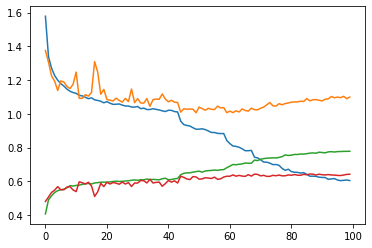

In [33]:
import pickle
pickle.dump(hist, open('./residual_baseline_hist.hdf5', 'wb'))
plt.plot(hist), best_acc, curloss

In [34]:
# EVALUATE
model = torch.load('./residual_baseline_model.pt')
model.eval()
running_valloss = 0.0
running_valacc = 0.0
_preds = []
_labels = []
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    acc = float((torch.argmax(outputs, dim=1) == labels).float().sum())
    loss = criterion(outputs, labels)

    #         print('\t - Step %d: loss: %.3f acc: %.3f' % (i+1, loss.item(), acc))

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc
    
    _preds.append(torch.argmax(outputs, dim=1).cpu().numpy())
    _labels.append(labels.cpu().numpy())

_preds = np.concatenate(_preds)
_labels = np.concatenate(_labels)
print('- Avg. val_loss: %.3f  | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.036  | Avg. val_acc: 0.649


Text(0.5, 1, 'baseline')

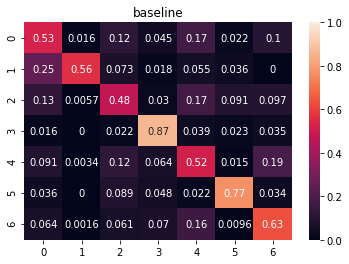

In [35]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

sn.heatmap(confusion_matrix(_labels, _preds, normalize='true'), annot=True, vmin=0, vmax=1)
plt.title('baseline')

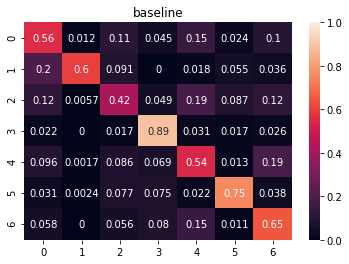

### Compare between baseline vs. residual baseline

In [2]:
import pickle
baseline_hist = pickle.load(open('./baseline_hist.hdf5', 'rb'))
residual_hist = pickle.load(open('./residual_baseline_hist.hdf5', 'rb'))

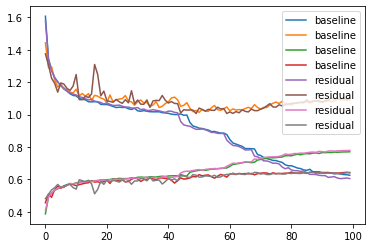

In [6]:
plt.plot(baseline_hist, label='baseline')
plt.plot(residual_hist, label='residual')

plt.legend()

plt.show()

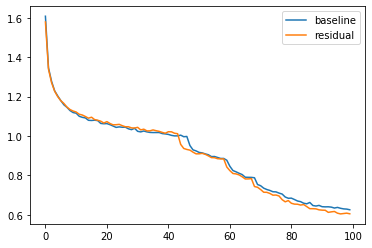

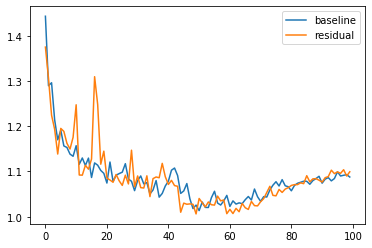

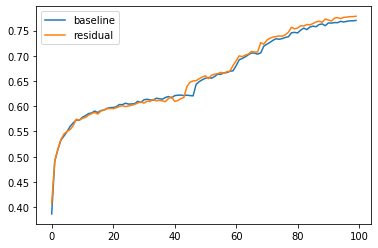

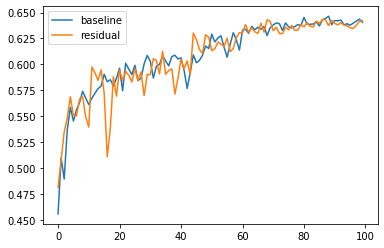

In [10]:
plt.plot([k[0] for k in baseline_hist], label='baseline')
plt.plot([k[0] for k in residual_hist], label='residual')
plt.legend()
plt.show()

plt.plot([k[1] for k in baseline_hist], label='baseline')
plt.plot([k[1] for k in residual_hist], label='residual')
plt.legend()
plt.show()

plt.plot([k[2] for k in baseline_hist], label='baseline')
plt.plot([k[2] for k in residual_hist], label='residual')
plt.legend()
plt.show()

plt.plot([k[3] for k in baseline_hist], label='baseline')
plt.plot([k[3] for k in residual_hist], label='residual')
plt.legend()
plt.show()

**Add residual does not significantly improve the baseline model**

### Feature Act 4

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.sm = nn.Softmax(dim=1)

        # pool to fix H and W size
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        # sm_cor = self.sm(cor)
        sm_cor = cor / torch.norm(cor)

        # with torch.no_grad():
        #   sm_cor += torch.randn(sm_cor.size()).to(device)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)

        cor_feature = self.pool(cor_feature)
        # cor_feature = self.sigmoid(cor_feature)

        # print('cor feature sigmoid: ', cor_feature)
        target_x = target_x * (1 + cor_feature)

        return target_x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.conv0b = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.bn0b = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        x = self.conv0b(x)
        x = self.bn0b(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1b(x)
        x = self.bn1b(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2b(x)
        x = self.bn2b(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv3b(x)
        x = self.bn3b(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x = nn.Flatten()(xfact2_3)
        x = self.classifier(x)
        
        return x

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [ ]:
model_path = './feature_act_4_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.2931315898895264 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.757 | Avg.acc: 0.325



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.516 | Avg. val_acc: 0.401
* Update optimal model
Epoch:  2


Loss=0.8761873245239258 Batch_id=224 Accuracy=0.8378378378378378: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.401 | Avg.acc: 0.463



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.318 | Avg. val_acc: 0.497
* Update optimal model
Epoch:  3


Loss=1.4969123601913452 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [01:18<00:00,  2.86it/s]

- Avg.loss: 1.300 | Avg.acc: 0.503



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.264 | Avg. val_acc: 0.515
* Update optimal model
Epoch:  4


Loss=1.315882921218872 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.254 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.213 | Avg. val_acc: 0.536
* Update optimal model
Epoch:  5


Loss=1.3352665901184082 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:17<00:00,  2.89it/s]

- Avg.loss: 1.223 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.212 | Avg. val_acc: 0.546
* Update optimal model
Epoch:  6


Loss=0.991359293460846 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:18<00:00,  2.88it/s]

- Avg.loss: 1.194 | Avg.acc: 0.546



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.508 | Avg. val_acc: 0.448
Epoch:  7


Loss=1.0742709636688232 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:18<00:00,  2.87it/s]

- Avg.loss: 1.182 | Avg.acc: 0.553



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.198 | Avg. val_acc: 0.540
Epoch:  8


Loss=1.13376784324646 Batch_id=4 Accuracy=0.5390625:   2%|▏         | 5/225 [00:03<02:36,  1.41it/s]  

### Feature Act 9b

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.src_gap_ln = nn.Linear(src_feature, src_feature)
        self.target_gap_ln = nn.Linear(target_feature, target_feature)

        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        # self.sm = nn.Softmax(dim=1)

    def forward(self, src_x, target_x):
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)
        src_gap = self.src_gap_ln(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)
        target_gap = self.target_gap_ln(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        # sm_cor = self.sm(cor)
        sm_cor = cor / torch.norm(cor)

        # with torch.no_grad():
        #   sm_cor += torch.randn(sm_cor.size()).to(device)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)
        cor_feature = self.relu(cor_feature)
        cor_feature = self.pool(cor_feature)

        # print('cor feature sigmoid: ', cor_feature)
        target_x = target_x * cor_feature

        return target_x, src_gap, target_gap

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        self.adaptive_avg = nn.AdaptiveAvgPool2d(output_size=(1,1))
        
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(736, 512), nn.BatchNorm1d(512), nn.ReLU(inplace=True),
                                            nn.Linear(512, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 7), nn.BatchNorm1d(7))
            
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1, src_0, tg_0 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2, src_1, tg_1 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3, src_2, tg_2 = self.fact2_3(x2, x3)
        xfact2_3 = self.adaptive_avg(xfact2_3)
        
        x_out = torch.cat([src_0, tg_0 + src_1, tg_1 + src_2, tg_2, nn.Flatten()(xfact2_3)], dim=1)
        
        x_out = self.classifier(x_out)
 
        return x_out

In [11]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [12]:
model_path = './feature_act_9b_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.7985868453979492 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.885 | Avg.acc: 0.247



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.849 | Avg. val_acc: 0.265
* Update optimal model
Epoch:  2


Loss=1.7945969104766846 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.799 | Avg.acc: 0.269



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.805 | Avg. val_acc: 0.260
Epoch:  3


Loss=1.818904995918274 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.736 | Avg.acc: 0.292



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.726 | Avg. val_acc: 0.302
* Update optimal model
Epoch:  4


Loss=1.818595290184021 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.574 | Avg.acc: 0.382



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.590 | Avg. val_acc: 0.388
* Update optimal model
Epoch:  5


Loss=1.6036311388015747 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.437 | Avg.acc: 0.446



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.741 | Avg. val_acc: 0.323
Epoch:  6


Loss=1.537320613861084 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.368 | Avg.acc: 0.474



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.588 | Avg. val_acc: 0.417
* Update optimal model
Epoch:  7


Loss=1.5620708465576172 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.327 | Avg.acc: 0.491



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.603 | Avg. val_acc: 0.419
* Update optimal model
Epoch:  8


Loss=1.525911569595337 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.301 | Avg.acc: 0.504



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.347 | Avg. val_acc: 0.501
* Update optimal model
Epoch:  9


Loss=1.302484154701233 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:42<00:00,  1.25s/it]

- Avg.loss: 1.270 | Avg.acc: 0.513



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.704 | Avg. val_acc: 0.351
Epoch:  10


Loss=1.2938297986984253 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 1.254 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.336 | Avg. val_acc: 0.485
Epoch:  11


Loss=0.9456105828285217 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.234 | Avg.acc: 0.527



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.420 | Avg. val_acc: 0.480
Epoch:  12


Loss=1.1713284254074097 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 1.220 | Avg.acc: 0.531



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.492 | Avg. val_acc: 0.440
Epoch:  13


Loss=1.3825199604034424 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.211 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.405 | Avg. val_acc: 0.480
Epoch:  14


Loss=1.1014517545700073 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.206 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.545 | Avg. val_acc: 0.431
Epoch:  15


Loss=1.361602783203125 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 1.184 | Avg.acc: 0.550



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.533 | Avg. val_acc: 0.424
Epoch:  16


Loss=1.211021065711975 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.185 | Avg.acc: 0.548



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.328 | Avg. val_acc: 0.520
* Update optimal model
Epoch:  17


Loss=1.1803783178329468 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.172 | Avg.acc: 0.552



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.215 | Avg. val_acc: 0.551
* Update optimal model
Epoch:  18


Loss=1.1878412961959839 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.172 | Avg.acc: 0.551



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.535
Epoch:  19


Loss=1.0300323963165283 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.159 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.595 | Avg. val_acc: 0.399
Epoch:  20


Loss=1.2637531757354736 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.154 | Avg.acc: 0.561



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.248 | Avg. val_acc: 0.531
Epoch:  21


Loss=1.0831265449523926 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.154 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.241 | Avg. val_acc: 0.545
Epoch:  22


Loss=1.2797839641571045 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.143 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.292 | Avg. val_acc: 0.539
Epoch:  23


Loss=1.0805957317352295 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 1.142 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.502 | Avg. val_acc: 0.448
Epoch:  24


Loss=1.2510814666748047 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.131 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.444 | Avg. val_acc: 0.480
Epoch:  25


Loss=0.9835065603256226 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.132 | Avg.acc: 0.567



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.338 | Avg. val_acc: 0.497
Epoch:  26


Loss=1.3110297918319702 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.119 | Avg.acc: 0.570



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.334 | Avg. val_acc: 0.522
Epoch    26: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  27


Loss=1.2516863346099854 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:38<00:00,  1.24s/it]

- Avg.loss: 1.089 | Avg.acc: 0.584



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.176 | Avg. val_acc: 0.581
* Update optimal model
Epoch:  28


Loss=1.0919239521026611 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.072 | Avg.acc: 0.594



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.559
Epoch:  29


Loss=1.0541677474975586 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.071 | Avg.acc: 0.592



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.226 | Avg. val_acc: 0.549
Epoch:  30


Loss=1.2351027727127075 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 1.068 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.139 | Avg. val_acc: 0.581
Epoch:  31


Loss=1.1268599033355713 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:39<00:00,  1.24s/it]

- Avg.loss: 1.060 | Avg.acc: 0.593



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.197 | Avg. val_acc: 0.562
Epoch:  32


Loss=1.2462294101715088 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.056 | Avg.acc: 0.599



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.256 | Avg. val_acc: 0.532
Epoch:  33


Loss=1.0664560794830322 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:39<00:00,  1.24s/it]

- Avg.loss: 1.053 | Avg.acc: 0.600



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.206 | Avg. val_acc: 0.559
Epoch:  34


Loss=0.830261766910553 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.048 | Avg.acc: 0.603



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.559
Epoch:  35


Loss=1.1463861465454102 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.046 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.161 | Avg. val_acc: 0.582
* Update optimal model
Epoch:  36


Loss=1.112756371498108 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [04:39<00:00,  1.24s/it]

- Avg.loss: 1.047 | Avg.acc: 0.602



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.576
Epoch:  37


Loss=1.022321105003357 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:40<00:00,  1.24s/it]

- Avg.loss: 1.040 | Avg.acc: 0.605



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.136 | Avg. val_acc: 0.587
* Update optimal model
Epoch:  38


Loss=1.0815398693084717 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.035 | Avg.acc: 0.606



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.209 | Avg. val_acc: 0.565
Epoch:  39


Loss=0.9671574234962463 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:39<00:00,  1.24s/it]

- Avg.loss: 1.033 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.578
Epoch:  40


Loss=0.9366530179977417 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.032 | Avg.acc: 0.609



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.179 | Avg. val_acc: 0.567
Epoch:  41


Loss=1.274996042251587 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 1.030 | Avg.acc: 0.610



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.180 | Avg. val_acc: 0.561
Epoch:  42


Loss=1.191137433052063 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:39<00:00,  1.24s/it]

- Avg.loss: 1.032 | Avg.acc: 0.608



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.214 | Avg. val_acc: 0.554
Epoch:  43


Loss=0.9520783424377441 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.024 | Avg.acc: 0.611



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.190 | Avg. val_acc: 0.591
* Update optimal model
Epoch:  44


Loss=1.2261613607406616 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.027 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.244 | Avg. val_acc: 0.563
Epoch:  45


Loss=1.1723841428756714 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [04:39<00:00,  1.24s/it]

- Avg.loss: 1.027 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.187 | Avg. val_acc: 0.582
Epoch:  46


Loss=1.1348143815994263 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 1.024 | Avg.acc: 0.607



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.199 | Avg. val_acc: 0.565
Epoch    46: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  47


Loss=0.941319465637207 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 0.992 | Avg.acc: 0.623



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.165 | Avg. val_acc: 0.594
* Update optimal model
Epoch:  48


Loss=0.8119149208068848 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [04:42<00:00,  1.25s/it]

- Avg.loss: 0.980 | Avg.acc: 0.631



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.129 | Avg. val_acc: 0.606
* Update optimal model
Epoch:  49


Loss=1.3181027173995972 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.980 | Avg.acc: 0.629



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.599
Epoch:  50


Loss=0.9064098000526428 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:43<00:00,  1.26s/it]

- Avg.loss: 0.970 | Avg.acc: 0.634



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.144 | Avg. val_acc: 0.583
Epoch:  51


Loss=1.018214464187622 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 0.971 | Avg.acc: 0.630



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.157 | Avg. val_acc: 0.598
Epoch:  52


Loss=0.8913091421127319 Batch_id=224 Accuracy=0.7567567567567568: 100%|██████████| 225/225 [04:42<00:00,  1.26s/it]

- Avg.loss: 0.971 | Avg.acc: 0.633



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.169 | Avg. val_acc: 0.578
Epoch:  53


Loss=1.2943577766418457 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it]

- Avg.loss: 0.968 | Avg.acc: 0.632



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.160 | Avg. val_acc: 0.589
Epoch:  54


Loss=0.6920551061630249 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it]

- Avg.loss: 0.962 | Avg.acc: 0.635



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.123 | Avg. val_acc: 0.604
Epoch:  55


Loss=1.0320022106170654 Batch_id=8 Accuracy=0.640625:   4%|▎         | 8/225 [00:13<05:12,  1.44s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8568483591079712 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.910 | Avg.acc: 0.655



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.612
Epoch    72: reducing learning rate of group 0 to 2.5000e-04.
Epoch:  73


Loss=0.7229138612747192 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.897 | Avg.acc: 0.661



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.140 | Avg. val_acc: 0.619
* Update optimal model
Epoch:  74


Loss=1.0879936218261719 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.888 | Avg.acc: 0.662



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.173 | Avg. val_acc: 0.617
Epoch:  75


Loss=0.6430436968803406 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.891 | Avg.acc: 0.663



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.170 | Avg. val_acc: 0.608
Epoch:  76


Loss=0.7570425271987915 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.888 | Avg.acc: 0.665



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.146 | Avg. val_acc: 0.614
Epoch:  77


Loss=0.8661787509918213 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [04:46<00:00,  1.27s/it]

- Avg.loss: 0.887 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.182 | Avg. val_acc: 0.607
Epoch:  78


Loss=0.98142409324646 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it]

- Avg.loss: 0.884 | Avg.acc: 0.667



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.158 | Avg. val_acc: 0.610
Epoch:  79


Loss=0.9165382385253906 Batch_id=128 Accuracy=0.625:  57%|█████▋    | 128/225 [02:45<02:02,  1.26s/it]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.9892778396606445 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:14<00:00,  3.01it/s]

- Avg.loss: 0.867 | Avg.acc: 0.675



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.617
Epoch:  98


Loss=0.6713405251502991 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.865 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.612
Epoch:  99


Loss=1.0335298776626587 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:14<00:00,  3.01it/s]

- Avg.loss: 0.863 | Avg.acc: 0.679



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.151 | Avg. val_acc: 0.615
Epoch    99: reducing learning rate of group 0 to 3.1250e-05.
Epoch:  100


Loss=0.942821204662323 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.01it/s]

- Avg.loss: 0.858 | Avg.acc: 0.678


- Avg. val_loss: 1.151 | Avg. val_acc: 0.613
Finished Training


([<matplotlib.lines.Line2D at 0x7febbbfebe80>,
 0.6188353301755364)

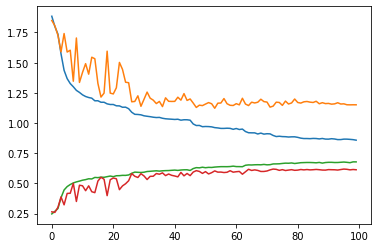

In [13]:
plt.plot(hist), best_acc

### Feature Act 10

In [6]:
import math
class FeatureAct(nn.Module):
    def __init__(self, src_feature, target_feature):
        super(FeatureAct, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.src_gap_ln = nn.Linear(src_feature, src_feature)
        self.target_gap_ln = nn.Linear(target_feature, target_feature)

        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.sm = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, src_x, target_x):
        src_gap = self.gap(src_x)
        src_gap = nn.Flatten()(src_gap)
        src_gap = self.src_gap_ln(src_gap)

        target_gap = self.gap(target_x)
        target_gap = nn.Flatten()(target_gap)
        target_gap = self.target_gap_ln(target_gap)

        cor = torch.bmm(src_gap.unsqueeze(-1), target_gap.unsqueeze(1))
        sm_cor = cor / torch.norm(cor)
        sm_cor = self.sm(cor)

        # with torch.no_grad():
        #   sm_cor += torch.randn(sm_cor.size()).to(device)

        cor_feature = torch.cat([(src_x * sm_cor[:, :, k, None, None]).sum(1).unsqueeze(1) for k in range(target_gap.size(1))], dim=1)
        cor_feature = self.pool(cor_feature)
        cor_feature = self.sigmoid(cor_feature)

        # print('cor feature sigmoid: ', cor_feature)
        target_x = target_x * cor_feature

        return target_x

In [7]:
class BaselineFeatureAct(nn.Module):
    def __init__(self, embeddings=False):
        
        super(BaselineFeatureAct, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        
        self.conv0 = nn.Conv2d(1, 32, kernel_size=(3,3), padding=1, stride=1)
        self.bn0 = nn.BatchNorm2d(32)
        
        self.conv1 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(256)
  
        self.fact0_1 = FeatureAct(32, 64)
        self.fact1_2 = FeatureAct(64, 128)
        self.fact2_3 = FeatureAct(128, 256)
        
        
        if not embeddings:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
                                            nn.Linear(128, 7), nn.BatchNorm1d(7))
            
        else:
            self.classifier = nn.Sequential(nn.Flatten(),
                                            nn.Linear(2304, 256), nn.BatchNorm1d(256), nn.ReLU(inplace=True),
                                            nn.Linear(256, 128), nn.BatchNorm1d(128))
        
    def forward(self, x):
        
        x = self.conv0(x)
        x = self.bn0(x)
        x = self.relu(x)
        
        x0 = self.maxpool(x)
        
        x = self.conv1(x0)
        x = self.bn1(x)
        x = self.relu(x)
        
        x1 = self.maxpool(x)

        xfact0_1 = self.fact0_1(x0, x1)
        
        x = self.conv2(xfact0_1)
        x = self.bn2(x)
        x = self.relu(x)
        
        x2 = self.maxpool(x)

        xfact1_2 = self.fact1_2(x1, x2)
        
        x = self.conv3(xfact1_2)
        x = self.bn3(x)
        x = self.relu(x)
        
        x3 = self.maxpool(x)

        xfact2_3 = self.fact2_3(x2, x3)
        
        x_out = self.classifier(xfact2_3)
                
        return x_out

In [8]:
device = torch.device('cuda')
model = BaselineFeatureAct().to(device)

best_acc = 0.0
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)


In [9]:
model_path = './feature_act_10_model.pt'

for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.4631153345108032 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:13<00:00,  3.04it/s]

- Avg.loss: 1.603 | Avg.acc: 0.386



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.408 | Avg. val_acc: 0.469
* Update optimal model
Epoch:  2


Loss=1.4965957403182983 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.345 | Avg.acc: 0.487



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.414 | Avg. val_acc: 0.452
Epoch:  3


Loss=1.2363646030426025 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.272 | Avg.acc: 0.513



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.286 | Avg. val_acc: 0.518
* Update optimal model
Epoch:  4


Loss=1.37601637840271 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.233 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.195 | Avg. val_acc: 0.540
* Update optimal model
Epoch:  5


Loss=0.9715834856033325 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.202 | Avg.acc: 0.543



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.311 | Avg. val_acc: 0.513
Epoch:  6


Loss=1.02411687374115 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.01it/s]

- Avg.loss: 1.183 | Avg.acc: 0.547



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.312 | Avg. val_acc: 0.522
Epoch:  7


Loss=1.4304800033569336 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.167 | Avg.acc: 0.556



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.567
* Update optimal model
Epoch:  8


Loss=0.9679185152053833 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.150 | Avg.acc: 0.564



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.163 | Avg. val_acc: 0.562
Epoch:  9


Loss=1.0573205947875977 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.133 | Avg.acc: 0.568



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.134 | Avg. val_acc: 0.567
Epoch:  10


Loss=1.2188613414764404 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.127 | Avg.acc: 0.573



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.113 | Avg. val_acc: 0.580
* Update optimal model
Epoch:  11


Loss=1.170047402381897 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.115 | Avg.acc: 0.576



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.126 | Avg. val_acc: 0.586
* Update optimal model
Epoch:  12


Loss=1.2338767051696777 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.112 | Avg.acc: 0.577



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.582
Epoch:  13


Loss=0.9190183281898499 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.107 | Avg.acc: 0.582



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.132 | Avg. val_acc: 0.570
Epoch:  14


Loss=0.9581936001777649 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.095 | Avg.acc: 0.586



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.096 | Avg. val_acc: 0.586
Epoch:  15


Loss=1.0543025732040405 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.086 | Avg.acc: 0.587



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.585
Epoch:  16


Loss=1.1649531126022339 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 1.086 | Avg.acc: 0.589



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.101 | Avg. val_acc: 0.582
Epoch:  17


Loss=1.2613065242767334 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.081 | Avg.acc: 0.588



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.122 | Avg. val_acc: 0.578
Epoch:  18


Loss=1.1625343561172485 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.078 | Avg.acc: 0.590



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.118 | Avg. val_acc: 0.586
Epoch:  19


Loss=0.9268594980239868 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.071 | Avg.acc: 0.595



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.115 | Avg. val_acc: 0.580
Epoch:  20


Loss=1.021140694618225 Batch_id=187 Accuracy=0.578125:  84%|████████▎ | 188/225 [01:02<00:11,  3.10it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.3019310235977173 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.016 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.099 | Avg. val_acc: 0.585
Epoch:  37


Loss=0.7976472973823547 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 1.020 | Avg.acc: 0.613



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.148 | Avg. val_acc: 0.586
Epoch:  38


Loss=1.0314440727233887 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.018 | Avg.acc: 0.615



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.085 | Avg. val_acc: 0.593
Epoch:  39


Loss=1.507149577140808 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.019 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.076 | Avg. val_acc: 0.605
Epoch:  40


Loss=0.7511909008026123 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 1.016 | Avg.acc: 0.614



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.080 | Avg. val_acc: 0.591
Epoch    40: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  41


Loss=0.9410606622695923 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [01:13<00:00,  3.04it/s]

- Avg.loss: 0.970 | Avg.acc: 0.637



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.036 | Avg. val_acc: 0.615
* Update optimal model
Epoch:  42


Loss=0.8992782831192017 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.950 | Avg.acc: 0.643



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.038 | Avg. val_acc: 0.622
* Update optimal model
Epoch:  43


Loss=0.9225732088088989 Batch_id=94 Accuracy=0.640625:  42%|████▏     | 95/225 [00:32<00:41,  3.10it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=1.1780855655670166 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.877 | Avg.acc: 0.669



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.029 | Avg. val_acc: 0.615
Epoch:  61


Loss=0.8927781581878662 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.881 | Avg.acc: 0.668



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.620
Epoch:  62


Loss=0.9650542736053467 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.04it/s]

- Avg.loss: 0.877 | Avg.acc: 0.672



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.035 | Avg. val_acc: 0.625
Epoch    62: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  63


Loss=1.0891997814178467 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [01:14<00:00,  3.01it/s]

- Avg.loss: 0.840 | Avg.acc: 0.684



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.021 | Avg. val_acc: 0.624
Epoch:  64


Loss=0.6596710681915283 Batch_id=224 Accuracy=0.7297297297297297: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.816 | Avg.acc: 0.695



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.004 | Avg. val_acc: 0.631
* Update optimal model
Epoch:  65


Loss=0.569425106048584 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.814 | Avg.acc: 0.694



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.014 | Avg. val_acc: 0.625
Epoch:  66


Loss=0.9667026996612549 Batch_id=217 Accuracy=0.625:  97%|█████████▋| 218/225 [01:12<00:02,  3.24it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Loss=0.8218258619308472 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.682 | Avg.acc: 0.747



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.052 | Avg. val_acc: 0.640
Epoch:  85


Loss=0.6682588458061218 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.674 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.051 | Avg. val_acc: 0.638
Epoch:  86


Loss=1.0166908502578735 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.677 | Avg.acc: 0.748



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.056 | Avg. val_acc: 0.637
Epoch:  87


Loss=0.6294503808021545 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.670 | Avg.acc: 0.751



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.060 | Avg. val_acc: 0.631
Epoch:  88


Loss=0.6058998107910156 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.03it/s]

- Avg.loss: 0.660 | Avg.acc: 0.756



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.063 | Avg. val_acc: 0.632
Epoch:  89


Loss=0.5367361307144165 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.671 | Avg.acc: 0.750



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.068 | Avg. val_acc: 0.635
Epoch:  90


Loss=0.7354590892791748 Batch_id=224 Accuracy=0.7837837837837838: 100%|██████████| 225/225 [01:14<00:00,  3.02it/s]

- Avg.loss: 0.659 | Avg.acc: 0.760



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.057 | Avg. val_acc: 0.640
Epoch:  91


Loss=0.5812726616859436 Batch_id=116 Accuracy=0.828125:  52%|█████▏    | 117/225 [00:39<00:35,  3.08it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
import pickle
pickle.dump(hist, open('./feature_act_10_hist.hdf5', 'wb'))

([<matplotlib.lines.Line2D at 0x7fef84815208>,
 0.6405684034550014)

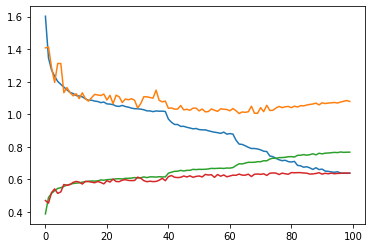

In [10]:
plt.plot(hist), best_acc

In [11]:
model = torch.load('./feature_act_10_model.pt')

# EVALUATE
model.eval()
running_valloss = 0.0
running_valacc = 0.0
for i,data in enumerate(test_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    
    loss = criterion(outputs, labels)
    acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

    running_valloss += (loss.item() * inputs.size(0))
    running_valacc += acc.item()

print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

- Avg. val_loss: 1.027 | Avg. val_acc: 0.638


## Add triplet loss

In [7]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [11]:
model_path = './baseline_tripletloss.pt'
device = torch.device('cuda')
model=Baseline(embeddings=True)
model.to(device)

best_loss = 1e3
hist = []

epochs=50

criterion = nn.CrossEntropyLoss()

learning_rate = 0.004
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8, verbose=True)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

In [ ]:
for epoch in range(100):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
#     running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        embeddings = model(inputs)
        
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        
#         acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
#         running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i}')

    print('- Avg.loss: %.3f' % (running_loss / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
#     avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
#     running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        embeddings = model(inputs)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        

        running_valloss += (loss.item() * inputs.size(0))

    print('- Avg. val_loss: %.3f' % (running_valloss / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    
    scheduler.step(avgvalloss)

    hist.append([avgloss, avgvalloss])
    
    if best_loss > avgvalloss:
        best_loss = avgvalloss
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=0.1057901531457901 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s] 

- Avg.loss: 0.103



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.108
* Update optimal model
Epoch:  2


Loss=0.10689564794301987 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
* Update optimal model
Epoch:  3


Loss=0.1074071079492569 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.108
Epoch:  4


Loss=0.10878229141235352 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.107
Epoch:  5


Loss=0.10899460315704346 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.105
Epoch:  6


Loss=0.10470321029424667 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
* Update optimal model
Epoch:  7


Loss=0.10832250118255615 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  8


Loss=0.10736994445323944 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.108
Epoch:  9


Loss=0.09777899831533432 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  10


Loss=0.1078610047698021 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  11


Loss=0.09220985323190689 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  12


Loss=0.09583801031112671 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  13


Loss=0.10013246536254883 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  14


Loss=0.10031009465456009 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]


- Avg.loss: 0.102


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.105
Epoch:  15


Loss=0.10263319313526154 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch    15: reducing learning rate of group 0 to 2.0000e-03.
Epoch:  16


Loss=0.1089475005865097 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
* Update optimal model
Epoch:  17


Loss=0.1042950451374054 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s] 

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  18


Loss=0.09958044439554214 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  19


Loss=0.10087445378303528 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  20


Loss=0.10419227927923203 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  21


Loss=0.10668791830539703 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.104
Epoch:  22


Loss=0.10032140463590622 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  23


Loss=0.10548188537359238 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  24


Loss=0.10530705749988556 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  25


Loss=0.100258469581604 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]  

- Avg.loss: 0.102



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch    25: reducing learning rate of group 0 to 1.0000e-03.
Epoch:  26


Loss=0.10037489235401154 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  27


Loss=0.09672677516937256 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  28


Loss=0.09669945389032364 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  29


Loss=0.10422849655151367 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.16it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  30


Loss=0.1062685176730156 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s] 

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  31


Loss=0.10016380995512009 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  32


Loss=0.1026480495929718 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s] 

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.103
Epoch:  33


Loss=0.10064208507537842 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  34


Loss=0.10417351871728897 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  35


Loss=0.09510628134012222 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  36


Loss=0.09938575327396393 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.24it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  37


Loss=0.09779898077249527 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  38


Loss=0.10391625016927719 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  39


Loss=0.10146648436784744 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  40


Loss=0.09441796690225601 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  41


Loss=0.09773372858762741 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.20it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  42


Loss=0.10436741262674332 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.18it/s]

- Avg.loss: 0.101



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  43


Loss=0.09665431082248688 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  44


Loss=0.0994633361697197 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.14it/s] 

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  45


Loss=0.10136669874191284 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  46


Loss=0.10161598026752472 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  47


Loss=0.0940605029463768 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s] 

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  48


Loss=0.10190575569868088 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  49


Loss=0.09605785459280014 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  50


Loss=0.09704715013504028 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.19it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  51


Loss=0.09650896489620209 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  52


Loss=0.09557102620601654 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.11it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  53


Loss=0.10023536533117294 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  54


Loss=0.09480453282594681 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  55


Loss=0.1020902544260025 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s] 

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  56


Loss=0.09515486657619476 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  57


Loss=0.10387720912694931 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  58


Loss=0.10092296451330185 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  59


Loss=0.10363693535327911 Batch_id=224: 100%|██████████| 225/225 [00:31<00:00,  7.21it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  60


Loss=0.09852714836597443 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  61


Loss=0.09977546334266663 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.37it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch    61: reducing learning rate of group 0 to 5.0000e-04.
Epoch:  62


Loss=0.10770120471715927 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  63


Loss=0.10616803914308548 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
* Update optimal model
Epoch:  64


Loss=0.08778837323188782 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  65


Loss=0.10094255208969116 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  66


Loss=0.08920393884181976 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  67


Loss=0.09462576359510422 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.102
Epoch:  68


Loss=0.11380410939455032 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  69


Loss=0.10583440214395523 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  70


Loss=0.09755150228738785 Batch_id=224: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]

- Avg.loss: 0.100



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 0.101
Epoch:  71


Loss=0.09997683763504028 Batch_id=23:  10%|█         | 23/225 [00:03<00:26,  7.49it/s]

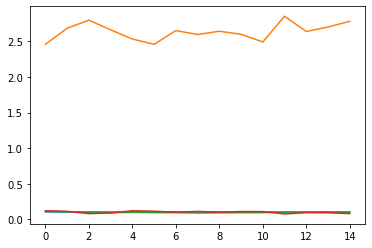

In [10]:
plt.plot(hist)